Demo notebook showing how to sample from a generative model
- Example 0: without any constraints
- Example 1.1: constraining the scaffold and generating one R group
- Example 1.2: constraining the scaffold and generating two R groups
- Example 2: constraining two pieces and generating the linker
- Example 3: generating from discrete choices

In [1]:
import os
import re

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit import DataStructs
import numpy as np

from gen_chem_1D.gen_models.reinvent.model import RNN, ScaffoldConstrainedRNN
from gen_chem_1D.gen_models.reinvent.tokenization import Vocabulary
from gen_chem_1D.gen_models.reinvent.utils import Variable, seq_to_smiles

from rdkit.Chem.Draw import IPythonConsole
import torch

In [2]:
OUT_DIR = 'figs_fexofenadine'
os.makedirs(OUT_DIR, exist_ok=True)

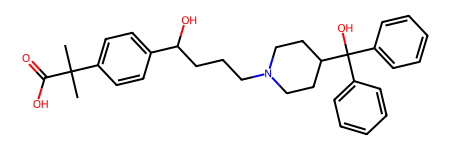

In [3]:
# these examples will focus on fexofenadine
fexofenadine_smi = 'CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(c3ccccc3)c4ccccc4'
fexofenadine_mol = Chem.MolFromSmiles(fexofenadine_smi)
fexofenadine_mol

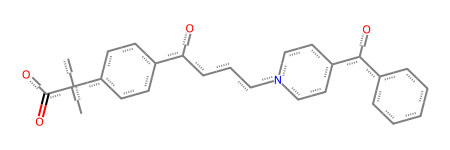

In [4]:
# use Hs to ensure it only matches this exact pattern
# [C][C]([C])([c]1[c][c][c]([c][c]1)[C]([C][C][C][N]2[C][C][C]([C][C]2)[C]([c]3[c][c][c][c][c]3)[O])[O])[C](=O)[O]
pattern = Chem.MolFromSmarts('[C][C]([C])([c]1[c][c][c]([c][c]1)[C]([C][C][C][N]2[C][C][C]([C][C]2)[C]([c]3[c][cH][cH][cH][c]3)[O])[O])[C](=O)[O]')
pattern

# Example 1: Sample without any constraints
- Use a model that was pretrained on ChEMBL. Weights are taken from: https://github.com/maxime-langevin/scaffold-constrained-generation/tree/master/data/DistributionLearningBenchmark 

In [5]:
# Load trained model and appropriate vocabulary
voc = Vocabulary(init_from_file="../../pretrained_models/reinvent/chembl/vocab.txt")
Agent = RNN(voc)
print(Agent.rnn.state_dict)
if torch.cuda.is_available():
    Agent.rnn.load_state_dict(torch.load('../../pretrained_models/reinvent/chembl/Prior_ChEMBL_randomized.ckpt'))
else:
    Agent.rnn.load_state_dict(torch.load('../../pretrained_models/reinvent/chembl/Prior_ChEMBL_randomized.ckpt', map_location=lambda storage, loc: storage))

<bound method Module.state_dict of MultiGRU(
  (embedding): Embedding(50, 128)
  (gru_1): GRUCell(128, 512)
  (gru_2): GRUCell(512, 512)
  (gru_3): GRUCell(512, 512)
  (linear): Linear(in_features=512, out_features=50, bias=True)
  (dropout_input): Dropout(p=0.0, inplace=False)
  (dropout_hidden): Dropout(p=0.0, inplace=False)
)>


REINVENT originally used a regular expression that could only parse individual characters so Br was represented by R and Cl was represented by L. Because R and L are not actual elements, we must always transform the generated SMILES by doing this conversion, which gets mildly annoying so we'll fix this later. However, because REINVENT originally sorted all vocab tokens, this means we can't just change R --> Br and L --> Cl in the vocab.txt file because upon sorting, the order of the tokens will be all jumbled it will mess up the mapping that converts generated indices to tokens whose sequence ultimately form a SMILES string.

In [6]:
voc.reversed_vocab

{0: '#',
 1: '%',
 2: '(',
 3: ')',
 4: '-',
 5: '0',
 6: '1',
 7: '2',
 8: '3',
 9: '4',
 10: '5',
 11: '6',
 12: '7',
 13: '8',
 14: '9',
 15: '=',
 16: 'C',
 17: 'F',
 18: 'L',
 19: 'N',
 20: 'O',
 21: 'R',
 22: 'S',
 23: '[CH]',
 24: '[N+]',
 25: '[N-]',
 26: '[NH+]',
 27: '[NH-]',
 28: '[NH2+]',
 29: '[NH3+]',
 30: '[N]',
 31: '[O+]',
 32: '[O-]',
 33: '[O]',
 34: '[S+]',
 35: '[S-]',
 36: '[SH+]',
 37: '[SH]',
 38: '[n+]',
 39: '[n-]',
 40: '[nH+]',
 41: '[nH]',
 42: '[o+]',
 43: '[s+]',
 44: 'c',
 45: 'n',
 46: 'o',
 47: 's',
 48: 'EOS',
 49: 'GO'}

In [7]:
seqs, agent_likelihood, entropy = Agent.sample(batch_size=100)
smiles = seq_to_smiles(seqs, voc)

In [8]:
smiles = np.unique(smiles)
smiles.shape

(100,)

In [9]:
mols = []
HIGHLIGHT_ATOMS_LIST = []
HIGHLIGHT_BONDS_LIST = []
LEGENDS = []
num_matches = 0
for i, s in enumerate(smiles):
    # their pretrained model generates R and L rather than Br and Cl
    s = s.replace("L", "Cl").replace("R", "Br")
    print(f'{i}: ', s)
    m = Chem.MolFromSmiles(s)
    if m:
        mols.append(m)
        # LEGENDS.append(s)
        LEGENDS.append(str(i))
        match = m.GetSubstructMatches(pattern)
        if match:
            HIGHLIGHT_ATOMS_LIST.append(match[0])
            num_matches += 1
        else:
            HIGHLIGHT_ATOMS_LIST.append([])
        HIGHLIGHT_BONDS_LIST.append([])   # append empty list to not highlight bonds

0:  C(=O)(NC(Cc1cccs1)C(=O)Nc1ccc(OC)cc1)c1noc2c1CN(C)CC2
1:  C(=O)(Nc1ccc(Cl)cc1)Cn1ncc(N2CCN(c3ccc(C(=N)N)cc3)CC2)c1
2:  C(C(Nc1cc(CNS(=O)(=O)C)c(OC)cc1)=O)c1ccc2c(c1)OCO2
3:  C(CC1(C)CCc2cc(OC)c(O)c(Cl)c2C1)C
4:  C(CN(C)C)N(c1ccc(NC(C)=O)cc1)C(=O)C
5:  C(NS(=O)(=O)c1ccsc1C(Nc1c(CC)cccc1CC)=O)c1cc(C(F)(F)F)cc(C(F)(F)F)c1
6:  C(O)(C(CC)C)(O)c1ccoc1
7:  C(OCc1c(Cl)cccc1)(C1C(c2ccccc2)C1C(=O)O)=O
8:  C([n+]1ccc(C=NO)cc1)N1C(c2ccc(OC)cc2)CC(c2cc3c(cc2)[nH]cc3)=NC1=S
9:  C(c1cc(C)ccc1C)(=O)Nc1ccc(CN2CC(C)NCC2)cc1
10:  C(c1ccc2nc(CC(C)(C)C)c(NC(=O)c3cc4cc(Br)ccc4oc3=O)oc2c1)#N
11:  C1(=Cc2ccc(O)c(O)c2)C(=O)c2c(O)c3c(C)coc3c(C)c2O1
12:  C1(C)(C)C2CC1CC2
13:  C1(OS(=O)(O)=O)C2C(C(O)C(O)C1)C1CCC3C(C)(C1(C)CC2)CCC1C(C)(C)C(=O)CCC13O
14:  C12CCc3c(ccc(OC(=O)c4ccc(C(N(C)C)=O)cc4)c3)C13N(C)C(=S)NC2Cc1ccc(OC)cc13
15:  C1C(C(=O)Nc2ccc(S(=O)(=O)Nc3c(N)ccc(Cl)c3)cc2)=C(Cl)C1
16:  C1C(c2onc(-c3ncccc3)n2)=C(C(=O)OCC)c2nc(-c3ccc(Cl)cc3Cl)[nH]c2C1=O
17:  C1CN(CC(=O)c2c3c(cc(C)cc3)[nH]c2)CCN1CCCNc1c2c(c3c

[11:41:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 29 30
[11:41:44] SMILES Parse Error: unclosed ring for input: 'C=CCSc1c2oc3c(c-2c2c(n1)-c1cc4c(c(=O)n1CC1CC1)C1(c5c(ccc(O)c5OC3=O)C1)CC(C(OC)=O)C5)C(=O)CCC42'
[11:41:44] Can't kekulize mol.  Unkekulized atoms: 6
[11:41:44] SMILES Parse Error: unclosed ring for input: 'c1cc(OCCN2CCN(c3cc4nc5c(c(O)n3c5cc(C#N)cc4)ccc5C)CC2)cc(F)c1C'


In [10]:
print(f'{num_matches} molecules contained the Fexofenadine scaffold')

0 molecules contained the Fexofenadine scaffold


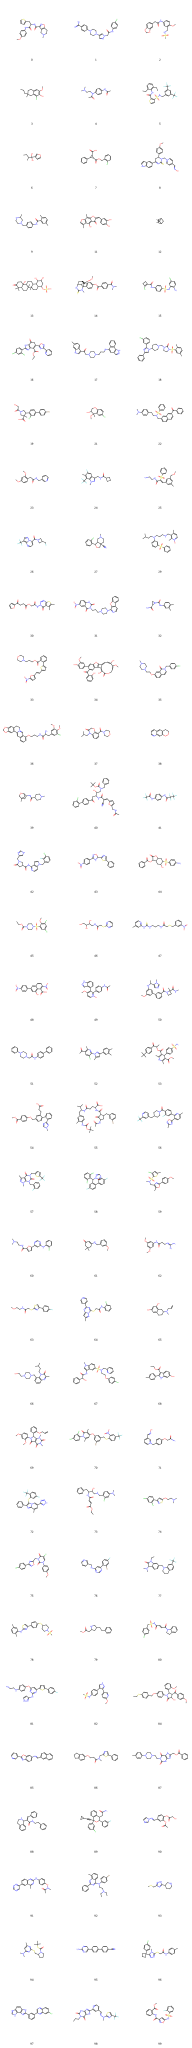

In [11]:
size = 375
img = Draw.MolsToGridImage(mols,
                           legends=LEGENDS,
                           subImgSize=(size, size),
                           highlightAtomLists=HIGHLIGHT_ATOMS_LIST,
                           highlightBondLists=HIGHLIGHT_BONDS_LIST,
                           highlightAtomColors=[{i: (0.4, 0.9, 0.1) for i in range(100)}]*len(mols),
                           molsPerRow=3,
                           useSVG=True,
                           maxMols=999,
                           )
img

In [12]:
with open(f'{OUT_DIR}/RNN_sample.svg', 'w') as f:
    f.write(img.data)

# Constrained generation

In [13]:
# Loading trained model and appropriate vocabulary
voc = Vocabulary(init_from_file="../../pretrained_models/reinvent/chembl/vocab.txt")
    
Agent = ScaffoldConstrainedRNN(voc)
print(Agent.rnn.state_dict)
if torch.cuda.is_available():
    Agent.rnn.load_state_dict(torch.load('../../pretrained_models/reinvent/chembl/Prior_ChEMBL_randomized.ckpt'))
else:
    Agent.rnn.load_state_dict(torch.load('../../pretrained_models/reinvent/chembl/Prior_ChEMBL_randomized.ckpt', map_location=lambda storage, loc: storage))

<bound method Module.state_dict of MultiGRU(
  (embedding): Embedding(50, 128)
  (gru_1): GRUCell(128, 512)
  (gru_2): GRUCell(512, 512)
  (gru_3): GRUCell(512, 512)
  (linear): Linear(in_features=512, out_features=50, bias=True)
  (dropout_input): Dropout(p=0.0, inplace=False)
  (dropout_hidden): Dropout(p=0.0, inplace=False)
)>


# Example 1: Constrain the generation by replacing R groups

## Example 1.1. Replacing one R group

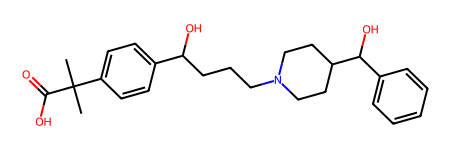

In [14]:
pattern = Chem.MolFromSmiles('CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)c4ccccc4')
pattern

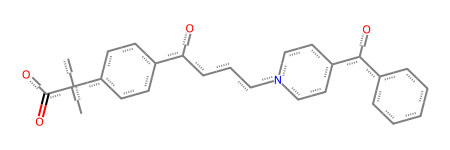

In [15]:
# use Hs to ensure it only matches this exact pattern
# [C][C]([C])([c]1[c][c][c]([c][c]1)[C]([C][C][C][N]2[C][C][C]([C][C]2)[C]([c]3[c][c][c][c][c]3)[O])[O])[C](=O)[O]
pattern = Chem.MolFromSmarts('[C][C]([C])([c]1[c][c][c]([c][c]1)[C]([C][C][C][N]2[C][C][C]([C][C]2)[C]([c]3[c][cH][cH][cH][c]3)[O])[O])[C](=O)[O]')
pattern

In [23]:
seqs, agent_likelihood, entropy = Agent.sample(pattern='CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(*)c4ccccc4', batch_size=100)
smiles = seq_to_smiles(seqs, voc)

In [24]:
smiles = np.unique(smiles)
smiles.shape

(55,)

In [25]:
mols = []
HIGHLIGHT_ATOMS_LIST = []
HIGHLIGHT_BONDS_LIST = []
LEGENDS = []
for i, s in enumerate(smiles):
    # their pretrained model generates R and L rather than Br and Cl
    s = s.replace("L", "Cl").replace("R", "Br")
    
    print(f'{i}: ', s)
    m = Chem.MolFromSmiles(s)
    # display(m)
    if m:
        match = m.GetSubstructMatches(pattern)
        mols.append(m)
        # LEGENDS.append(s)
        LEGENDS.append(str(i))
        HIGHLIGHT_ATOMS_LIST.append(match[0])
        HIGHLIGHT_BONDS_LIST.append([])   # append empty list to not highlight bonds

0:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(C#C)c4ccccc4
1:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(C#CCc2ccccc2)c4ccccc4
2:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(C(=O)NC(C(=O)O)CC(C)C)c4ccccc4
3:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(C(=O)NCC(C)C)c4ccccc4
4:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(C(=O)Nc2ccccc2OCCC)c4ccccc4
5:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(C(C(NC(=O)OCc2ccccc2)Cc2ccccc2)O)c4ccccc4
6:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(C(C=C)C=CC(OC)=O)c4ccccc4
7:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(C(F)(F)F)c4ccccc4
8:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(C)c4ccccc4
9:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(CC)c4ccccc4
10:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(CCOc2ccc(C(=O)C(=O)O)cc2)c4ccccc4
11:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(CN2C(=O)C(O)C(C)C2=O)c4ccccc4
12:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(CNC(=O)c2c(O)cccc2)c4ccccc4
13:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC

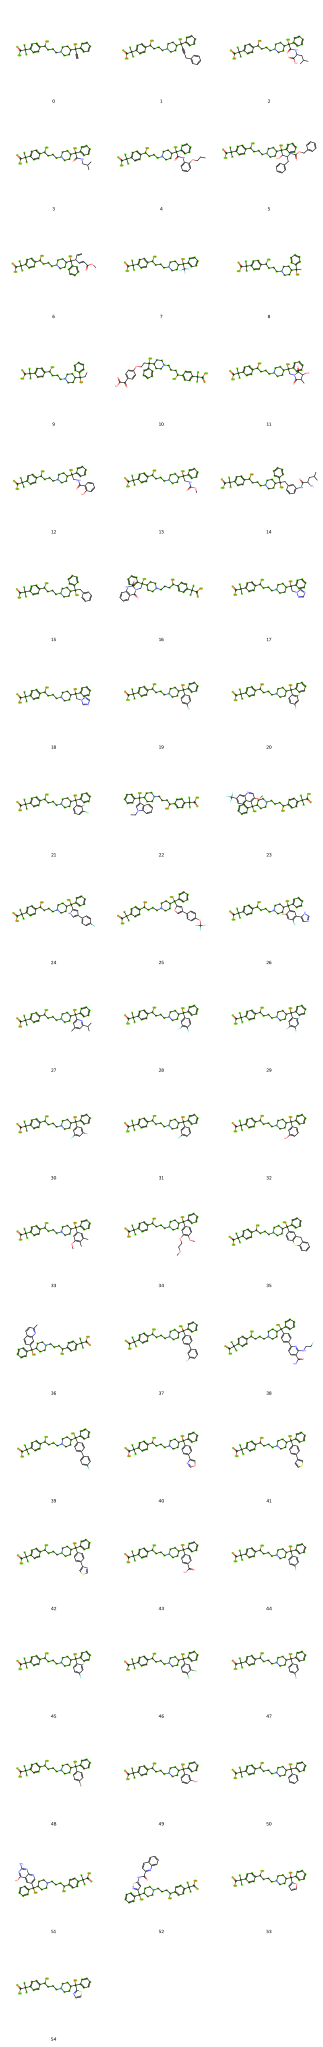

In [26]:
size = 375
img = Draw.MolsToGridImage(mols,
                           legends=LEGENDS,
                           subImgSize=(size, size),
                           highlightAtomLists=HIGHLIGHT_ATOMS_LIST,
                           highlightBondLists=HIGHLIGHT_BONDS_LIST,
                           highlightAtomColors=[{i: (0.4, 0.9, 0.1) for i in range(100)}]*len(mols),
                           molsPerRow=3,
                           useSVG=True,
                           maxMols=999,
                           )
img

In [27]:
with open(f'{OUT_DIR}/fexofenadine_replace_1_fragment.svg', 'w') as f:
    f.write(img.data)

## Example 2: replacing two R groups

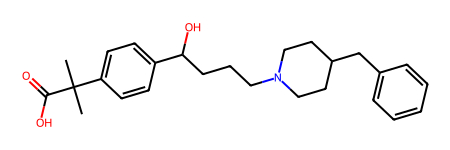

In [28]:
pattern = Chem.MolFromSmiles('CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)Cc4ccccc4')
pattern

In [31]:
seqs, agent_likelihood, entropy = Agent.sample(pattern='CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(*)(*)c4ccccc4', batch_size=100)
smiles = seq_to_smiles(seqs, voc)

In [32]:
smiles = np.unique(smiles)
smiles.shape

(86,)

In [33]:
mols = []
HIGHLIGHT_ATOMS_LIST = []
HIGHLIGHT_BONDS_LIST = []
LEGENDS = []
for i, s in enumerate(smiles):
    # their pretrained model generates R and L rather than Br and Cl
    s = s.replace("L", "Cl").replace("R", "Br")
    
    print(f'{i}: ', s)
    m = Chem.MolFromSmiles(s)
    if m:
        match = m.GetSubstructMatches(pattern)
        mols.append(m)
        # LEGENDS.append(s)
        LEGENDS.append(str(i))
        HIGHLIGHT_ATOMS_LIST.append(match[0])
        HIGHLIGHT_BONDS_LIST.append([])   # append empty list to not highlight bonds

0:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=NOCCO)(C)c4ccccc4
1:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(C#Cc2ccc(N)cc2)c4ccccc4
2:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(C#N)c4ccccc4
3:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(C(=C)C)c4ccccc4
4:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(C(=O)O)c4ccccc4
5:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(C(C)C)c4ccccc4
6:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(C(O)=O)c4ccccc4
7:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(C)c4ccccc4
8:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(C=CCl)c4ccccc4
9:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(CC)c4ccccc4
10:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(CC=NC(=O)OC(C)(C)C)c4ccccc4
11:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(CCC(=O)O)c4ccccc4
12:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(CCN)c4ccccc4
13:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(CCc2onc(CCC)n2)c4ccccc4
14:  CC(C)(C(=O)O)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(=O)(COc2ccc(C

[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom # 23 C, 5, is greater than permitted
[11:43:27] Explicit valence for atom #

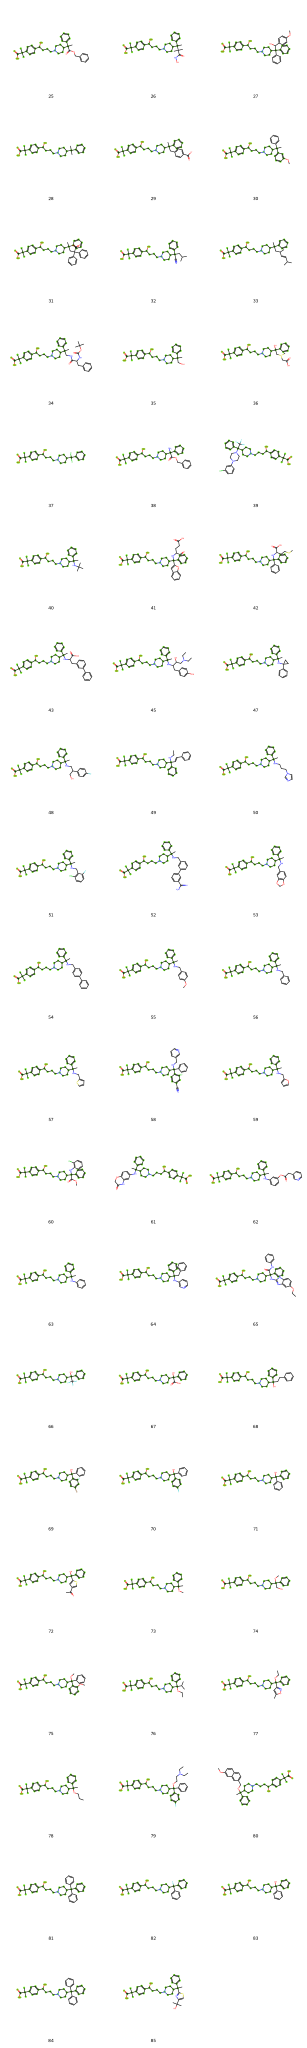

In [34]:
size = 375
img = Draw.MolsToGridImage(mols,
                           legends=LEGENDS,
                           subImgSize=(size, size),
                           highlightAtomLists=HIGHLIGHT_ATOMS_LIST,
                           highlightBondLists=HIGHLIGHT_BONDS_LIST,
                           highlightAtomColors=[{i: (0.4, 0.9, 0.1) for i in range(100)}]*len(mols),
                           molsPerRow=3,
                           useSVG=True,
                           maxMols=999,
                           )
img

In [36]:
with open(f'{OUT_DIR}/fexofenadine_replace_2_fragments.svg', 'w') as f:
    f.write(img.data)

# Example 2: Replacing a linker
e.g., break up the Fexofenadine molecule and create a linker

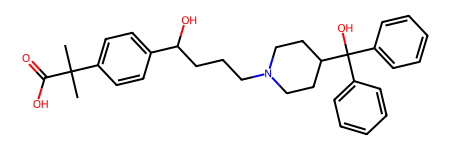

In [37]:
fexofenadine_mol

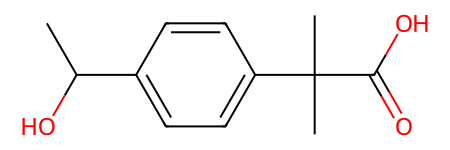

In [38]:
core1_smi = 'CC(C)(C(=O)O)c1ccc(cc1)C(O)C'
core1 = Chem.MolFromSmiles(core1_smi)
core1

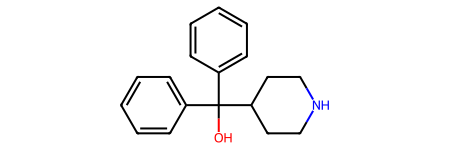

In [39]:
core2_smi = 'N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4'
core2 = Chem.MolFromSmiles(core2_smi)
core2

In [40]:
seqs, agent_likelihood, entropy = Agent.sample(pattern=f'{core1_smi}*{core2_smi}', batch_size=100, max_length=120)

In [41]:
smiles = seq_to_smiles(seqs, voc)

In [42]:
smiles = np.unique(smiles)
smiles.shape

(99,)

In [43]:
mols = []
LEGENDS = []
for i, s in enumerate(smiles):
    # their pretrained model generates R and L rather than Br and Cl
    s = s.replace("L", "Cl").replace("R", "Br")
    
    print(f'{i}: ', s)
    m = Chem.MolFromSmiles(s)
    if m:
        mols.append(m)
        LEGENDS.append(str(i))

0:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C#Cc1cc(OCc2cc3cc(C(=O)NCc4ccccn4)ccc3cc2)ccc1N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
1:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C#Cc1ccc2c(c(N)nc(N)n2)c1N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
2:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C(=O)N1CCN(S(=O)(c2ccc(Oc3ccccc3)cc2)=O)C1N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
3:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C(=O)NC(CC)N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
4:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C(=O)NC1C(=O)N2C(C(O)=O)=C(C(C)(C)C)NC(N)=C2C(=O)OC1N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
5:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C(=O)NCCN2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
6:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C(=O)NOCN2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
7:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C(=O)Nc1c(C(=O)O)cccc1N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
8:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C(=O)OCCN2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
9:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C(C(N(Cc1cccnc1)C(O)=O)CCOC)N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
10:  CC(C)(C(=O)O)c1ccc(cc1)C(O)C(C(O)C(CN(C)O)=Cc1cc(OC)c(O)cc1-c1ccc(Cl)cc1)N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4

[11:43:52] SMILES Parse Error: unclosed ring for input: 'CC(C)(C(=O)O)c1ccc(cc1)C(O)C(C)N1CCC(n2c3c(cc(NC)cc3)c3c2-c2c(c(C(=O)O)c4c(cccc4)n2)C3)CC1N2CCC(CC2)C(O)(c3ccccc3)c4cccc'
[11:43:52] Explicit valence for atom # 26 O, 3, is greater than permitted
[11:43:52] Explicit valence for atom # 30 O, 3, is greater than permitted
[11:43:52] SMILES Parse Error: ring closure 1 duplicates bond between atom 14 and atom 15 for input: 'CC(C)(C(=O)O)c1ccc(cc1)C(O)C1=C1CC(CO)N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4'
[11:43:52] Explicit valence for atom # 26 O, 3, is greater than permitted
[11:43:52] Explicit valence for atom # 18 N, 4, is greater than permitted
[11:43:52] SMILES Parse Error: extra close parentheses while parsing: CC(C)(C(=O)O)c1ccc(cc1)C(O)CC(C)=O)CC(N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4
[11:43:52] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C(=O)O)c1ccc(cc1)C(O)CC(C)=O)CC(N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4' for input: 'CC(C)(C(=O)O)c1ccc(cc1)C(O)CC(C)=O)CC(N2CCC(CC2)C(O)(c3ccccc3)c4ccccc4'


In [44]:
size = 375
img = Draw.MolsToGridImage(mols,
                           legends=LEGENDS,
                           subImgSize=(size, size),
                           highlightAtomLists=[mol.GetSubstructMatch(core1) + mol.GetSubstructMatch(core2) for mol in mols],
                           highlightBondLists=[[]]*len(mols),
                           highlightAtomColors=[{i: (0.4, 0.9, 0.1) for i in range(100)}]*len(mols),
                           molsPerRow=3,
                           useSVG=True,
                           maxMols=999,
                           )
img

In [45]:
with open(f'{OUT_DIR}/fexofenadine_replace_linker.svg', 'w') as f:
    f.write(img.data)

# Example 3: Discrete choices

In [46]:
# let's say we want to choose between putting either an oxygen or a carbon
# it's probably easier to just do these changes with regex, but it might be nice to combine with the functionality above
seqs, agent_likelihood, entropy = Agent.sample(pattern='CC(C)(C(=O)O)c1ccc(cc1)C([O,C])CCN2CCC(CC2)C(O)(c3ccccc3)c4ccccc4', batch_size=20)

In [47]:
smiles = seq_to_smiles(seqs, voc)

In [48]:
smiles = np.unique(smiles)
smiles.shape

(2,)

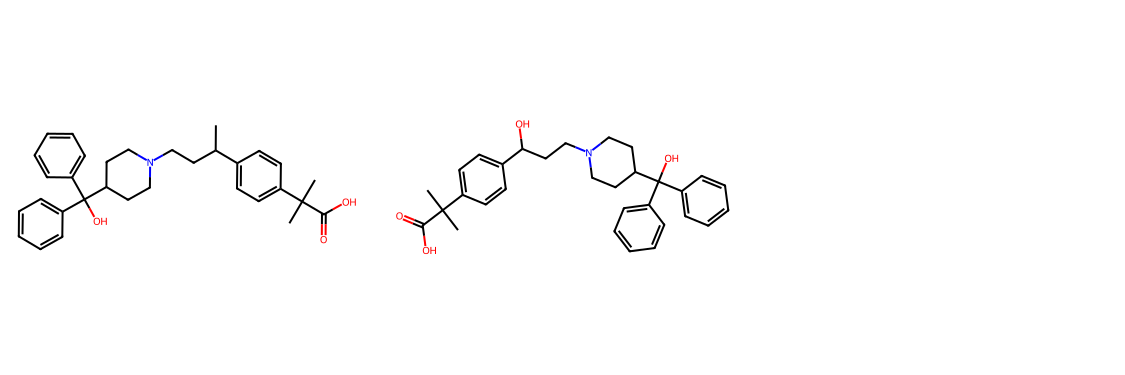

In [49]:
size = 375
img = Draw.MolsToGridImage([Chem.MolFromSmiles(s.replace("L", "Cl").replace("R", "Br")) for s in smiles],
                           subImgSize=(size, size),
                           molsPerRow=3,
                           useSVG=True,
                           maxMols=999,
                           )
img

In [50]:
with open(f'{OUT_DIR}/fexofenadine_dicrete_choices_methyl_vs_OH.svg', 'w') as f:
    f.write(img.data)